In [1]:
import os
from homoglypher.process_data import HomoglyphJSON
from homoglypher.glyph import Glyph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load in Unicode categories and the original file list of ttfs

In [2]:
uni_categories = pd.read_csv(
    "unicode_categories.tsv",
    delimiter='\t',
    header=None,
    names=['ABBR', 'LONG', 'DESCRIPTION']
)
uni_dict = dict(zip(uni_categories['ABBR'], uni_categories['LONG']))

with open("data_googlefonts_files.txt", 'r') as f:
    original_list = f.read().split("\n")
    original_list = set([f[:-4] for f in original_list])

Build a record for each font file

In [3]:
indir = "data_googlefonts"
fnames = os.listdir(indir)

records = []
for f in fnames:
    r = HomoglyphJSON(f, indir)
    records.append(r.record)

Compile into a big dataframe

In [4]:
fonts = pd.concat([r for r in records])
print(f"Number of entries: {len(fonts):,}")

Number of entries: 146,654


How many fonts from the original data have homoglyphs?

In [5]:
not_found = list(original_list - set(fonts.index))
print(f"No homoglyphs for {len(not_found)} files")

No homoglyphs for 272 files


Make character dataframe, where a row is a single character

In [5]:
chars = (
    fonts
    .drop_duplicates('DEC')
    .drop(columns=['GROUP', 'STYLE'])
    .sort_values('DEC')
    .reset_index(drop=True)
)

In [6]:
grouped_dec = fonts.groupby('DEC')
dec_counts = grouped_dec['HEX'].count()

print(
    f"Number of characters: {len(chars)}",
    f"\nCharacter that appears the most:",
    f"{hex(dec_counts.idxmax())}, which is {chr(dec_counts.idxmax())}",
    f"({dec_counts.max()} times)"
)

Number of characters: 6018 
Character that appears the most: 0x2d, which is - (1893 times)


Get the number of homoglyphs per each categorical in the fonts dataframe. This requires some complicated footwork: group by categorical, then `GROUP`; get the number of unique entries per grouped result; group by font file again; take the count.

Additionally: define functions to get the probability and conditional probability distributions for observations in the variables

In [7]:
def homoglyphs_per(var, df):
    h_per = (
        df
        .groupby([var, 'GROUP'])
        .nunique()
        .groupby(level=0)
        .size()
    )
    return {var: h_per}

def prob(cond, df):
    return (
        df
        .groupby(cond)
        .size()
        .div(len(df))
    )

def conditional_prob(cond1, cond2, df, fill_zeros=True):
    probs = prob(cond1, df)
    c_probs = (
        df
        .groupby([cond1, cond2])
        .size()
        .div(len(df))
        .div(probs, axis=0, level=cond1)
    )
    if fill_zeros:
        c_probs = (
            c_probs
            .unstack(fill_value=0)
            .stack()
        )
    c_probs = (
        c_probs
        .reset_index()
        .rename(columns={0: 'COND_PROB'})
    )
    
    return c_probs

In [8]:
var_list = ['FILE', 'FONT', 'STYLE', 'CAT']
h_per_var = [homoglyphs_per(var, fonts) for var in var_list]

In [10]:
for entry in h_per_var:
    for k, v in entry.items():
        print(
            f"Unique categories for {k}: {entry[k].count()}",
            f"\nMedian number of homoglyphs in {k}: {entry[k].median()}",
            f"\nMost number of homoglyphs for {k}: {entry[k].idxmax()} ({entry[k].max()})",
            f"\nLeast number of homoglyphs for {k}: {entry[k].idxmin()} ({entry[k].min()})",
            "\n"
        )

Unique categories for FILE: 2915 
Median number of homoglyphs in FILE: 5.0 
Most number of homoglyphs for FILE: SeoulHangangCondensed-Medium (497) 
Least number of homoglyphs for FILE: ABeeZee-Italic (1) 

Unique categories for FONT: 1241 
Median number of homoglyphs in FONT: 5.0 
Most number of homoglyphs for FONT: SeoulHangangCondensed (497) 
Least number of homoglyphs for FONT: ABeeZee (1) 

Unique categories for STYLE: 129 
Median number of homoglyphs in STYLE: 11.0 
Most number of homoglyphs for STYLE: Medium (497) 
Least number of homoglyphs for STYLE: Devanagari (1) 

Unique categories for CAT: 24 
Median number of homoglyphs in CAT: 160.0 
Most number of homoglyphs for CAT: Lo (469) 
Least number of homoglyphs for CAT: Lt (5) 



Plotting some histograms. Here, each graph is the number of variables with a given number of homoglyphs

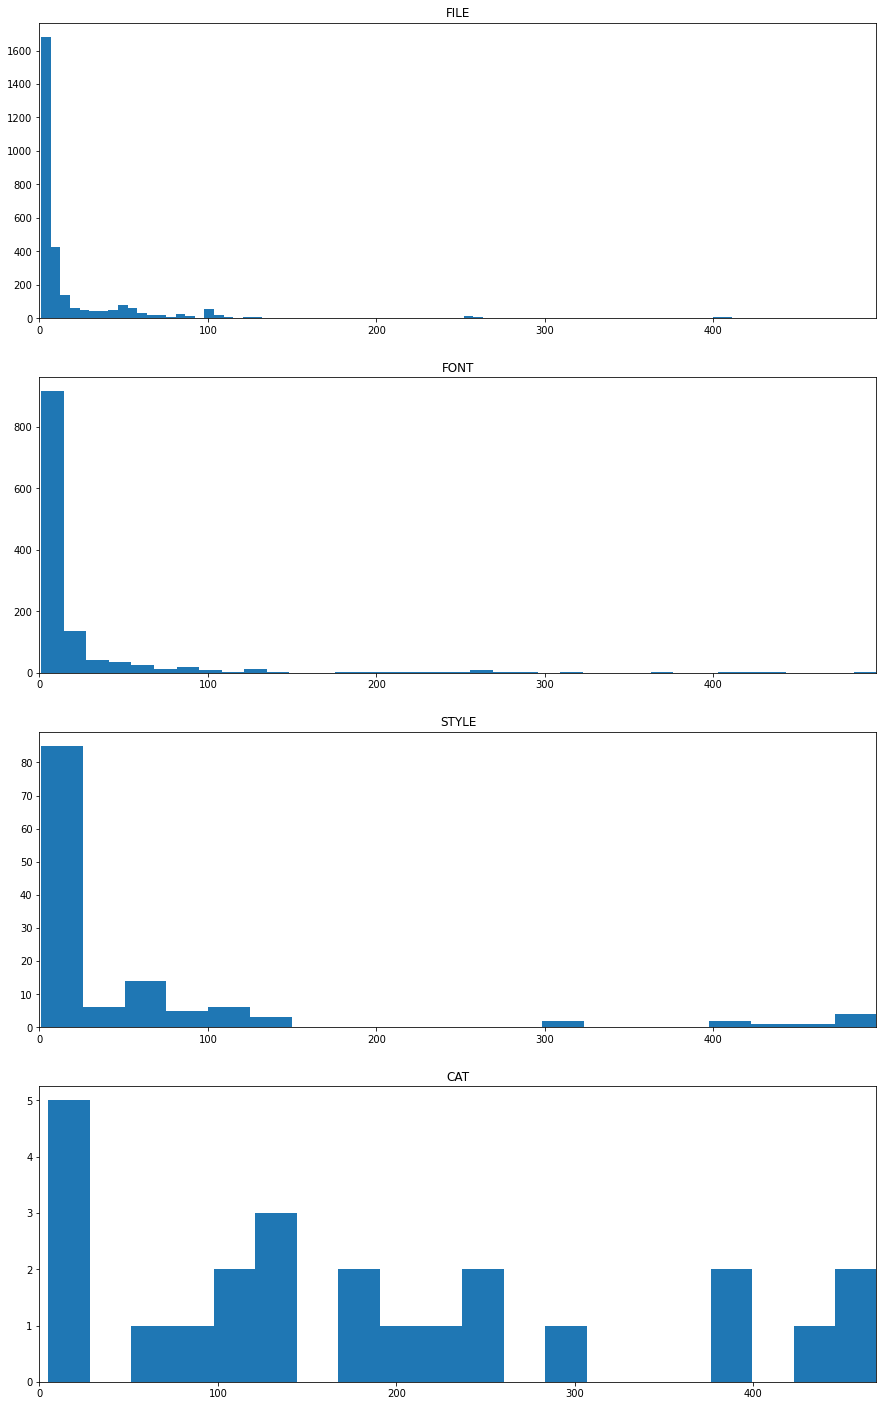

In [11]:
num_axes = len(h_per_var)
fig, ax = plt.subplots(num_axes, 1, figsize=(15, 25))

axes = ax.flatten()
for n, a in zip(range(num_axes), axes):
    var, to_plot = var_list[n], h_per_var[n]

    xrange = (0, to_plot[var].max())
    bins = round((len(to_plot[var]) * 0.03))
    if bins < 10:
        bins = 20
    
    a.hist(to_plot[var], bins=bins)
    a.set_title(var)
    a.set_xlim(xrange)

A quick glimpse at some probability distributions for the variables.

Here's `STYLE`

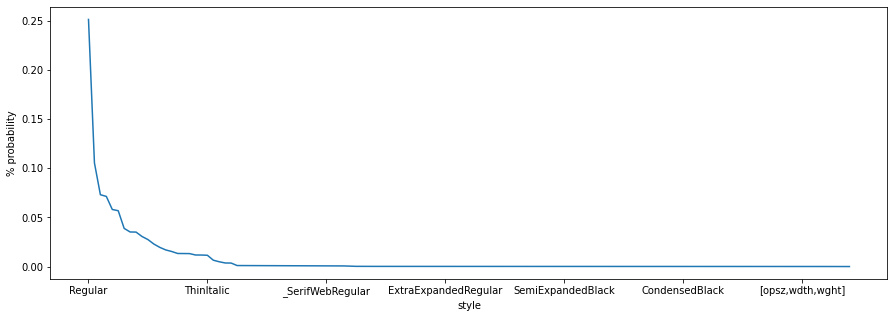

In [12]:
style_prob = prob('STYLE', fonts)

style_prob.sort_values(ascending=False).plot(figsize=(15,5), xlabel='style', ylabel='% probability');

Here's `CAT`, or the Unicode category

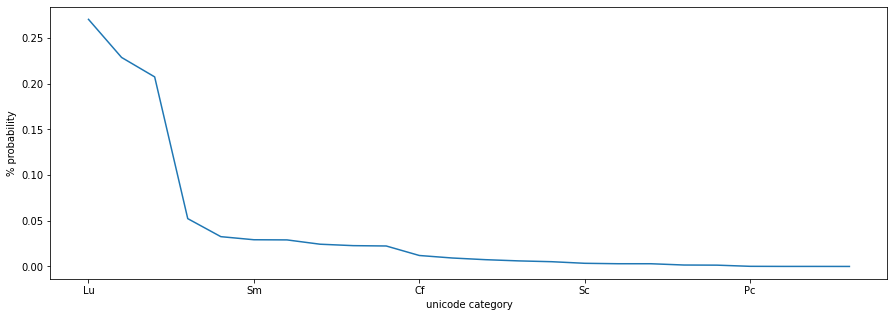

In [13]:
cat_prob = prob('CAT', fonts)
cat_prob = pd.DataFrame(cat_prob.sort_values(ascending=False), columns=['PROB'])
cat_prob = cat_prob.assign(LONG=cat_prob.index.map(uni_dict))

cat_prob.plot(figsize=(15,5), xlabel='unicode category', ylabel='% probability', legend=False);

In [14]:
cat_prob.round(6)

,PROB,LONG
CAT,,
Lu,0.270453,Uppercase_Letter
Lo,0.228770,Other_Letter
Ll,0.207488,Lowercase_Letter
So,0.052375,Other_Symbol
Pd,0.032648,Dash_Punctuation
Sm,0.029266,Math_Symbol
Po,0.029096,Other_Punctuation
Mn,0.024377,Nonspacing_Mark
Lm,0.022816,Modifier_Letter


Count the number of characters in each homoglyph for font. Put another way: for a given font, how many characters are in each `GROUP`?

In [15]:
char_per_h = pd.DataFrame(fonts.groupby(['FILE', 'GROUP']).size(), columns=['N_CHAR'])
char_per_h = (
    char_per_h
    .reset_index()
    .set_index('FILE')
)

char_arr = char_per_h['N_CHAR']

In [16]:
quant = 0.99
high_quant = char_arr.quantile(quant)

print(
    "Characters per homoglyph:",
    f"\n+ Mean: {char_arr.mean():.02f}",
    f"\n+ Standard deviation: {char_arr.std():.02f}",
    f"\n+ Variance: {char_arr.var():.02f}",
    f"\n+ Largest homoglyph group: {char_arr.max()} characters ({char_arr.idxmax()})",
    f"\n+ {quant} quantile for characters per homoglyph: {high_quant} characters",
    f"\n+ Number of fonts with a homoglyph that contains {high_quant} or more characters:",
    f"{char_per_h[char_per_h['N_CHAR'] >= high_quant].index.nunique()}"
)

Characters per homoglyph: 
+ Mean: 2.14 
+ Standard deviation: 1.86 
+ Variance: 3.47 
+ Largest homoglyph group: 223 characters (FlowRounded-Regular) 
+ 0.99 quantile for characters per homoglyph: 4.0 characters 
+ Number of fonts with a homoglyph that contains 4.0 or more characters: 514


Let's look at the distributions a little more

Second standard deviation + mean for the number of chars in a homoglyph: 5.87 characters 
Number of fonts with homoglyphs at or above this cutoff: 39


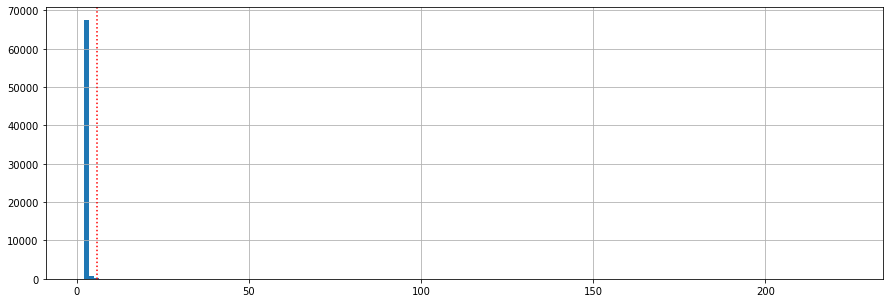

In [17]:
sigma_2 = char_arr.std() * 2
sig2_mean = sigma_2 + char_arr.mean()

print(
    f"Second standard deviation + mean for the number of chars in a homoglyph: {sig2_mean:.2f} characters",
    f"\nNumber of fonts with homoglyphs at or above this cutoff:",
    f"{char_per_h[char_per_h['N_CHAR'] >= sig2_mean].index.nunique()}"
)

ax = char_arr.hist(figsize=(15,5), bins=150)
plt.axvline(x=sig2_mean, color='red', ls=':');

Subset on files with these large homoglyph groups

In [18]:
lg_groups = char_per_h[char_per_h['N_CHAR'] >= sig2_mean]

lg_groups_files = lg_groups.groupby('FILE').size()
lg_groups_n_char = lg_groups.groupby('FILE')['N_CHAR'].sum()

In [19]:
print(
    f"Mean number of homoglyphs in the large groups subset: {lg_groups_files.mean():.2f}",
    f"\nFile with the most homoglyphs in this subset: {lg_groups_files.max()}",
    f"({lg_groups_n_char.idxmax()};",
    f"covers {lg_groups.loc[lg_groups_n_char.idxmax()]['N_CHAR'].sum()} characters)"
)

Mean number of homoglyphs in the large groups subset: 2.10 
File with the most homoglyphs in this subset: 8 (RedactedScript-Regular; covers 325 characters)


Interestingly, the top five or so files in this list are those that pressure the very idea of a font. More on this sometime...

In [20]:
lg_groups_n_char.sort_values(ascending=False).head(15)

FILE
RedactedScript-Regular        325
RedactedScript-Light          322
RedactedScript-Bold           314
FlowBlock-Regular             268
FlowCircular-Regular          265
FlowRounded-Regular           265
Cardo-Bold                    101
Cardo-Regular                 101
Cardo-Italic                   81
LakkiReddy-Regular             51
RaviPrakash-Regular            51
Ponnala-Regular                51
Nobile-Italic                  36
Tuffy-Italic                   26
PT_Sans-Narrow-Web-Regular     25
Name: N_CHAR, dtype: int64

Case in point

In [21]:
redacted_ttf = "fonts/RedactedScript-Regular.ttf"

redacted_reg = fonts.loc['RedactedScript-Regular']
for dec in redacted_reg.loc[redacted_reg['GROUP'] == 0, 'DEC']:
    g = Glyph(chr(dec))
    print(g.char)
    display(g.draw(redacted_ttf, 50))

0


1


2


3


4


=


@


P


Q


R


S


T


]


`


p


q


r


s


t


}


¡


±


²


³


´


µ


¾


Á


Ñ


Ò


Ó


Ô


Õ


Þ


á


ñ


ò


ó


ô


õ


þ


ā


ė


Ę


ę


Ě


ě


İ


ķ


ō


Ő


ő


Œ


œ


Ş


š


Ż


ż


Ž


ž


ƒ


˙


˜


‹


›


⁄


⁴


€


ℓ


∕


∞


Consider something like Paul Chan's Alternumerics series (which isn't actually in the `fonts` dataset---just illustrating)

A


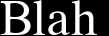

B


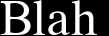

C


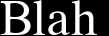

D


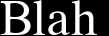

E


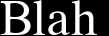

F


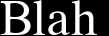

G


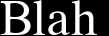

H


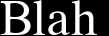

I


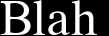

J


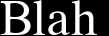

K


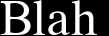

L


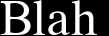

M


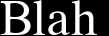

N


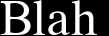

O


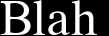

P


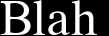

Q


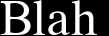

R


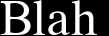

S


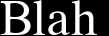

T


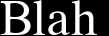

U


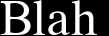

V


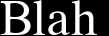

W


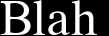

X


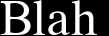

Y


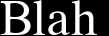

In [22]:
chan_ttf = "fonts/Font Politics to come.ttf"
for dec in range(65, 90):
    g = Glyph(chr(dec))
    print(g.char)
    display(g.draw(chan_ttf, 50))